In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
import seaborn as sns; sns.set()
sns.__version__

'0.11.1'

In [2]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='DejaVu Sans') 
# This should be replaced with Helvetica; 
# See https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [3]:
df_pair_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_pair_1985_2009.pkl")
df_paper_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_paper_1985_2009.pkl")
df_grant_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_grant_1985_2009.pkl")

In [4]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

In [6]:
#####----- A -----#####
df_tmp = df_pair_1985_2009[['grant_id','funding_usd','grant_interdisciplinarity_interval']].drop_duplicates()
funding_per_grantITD = summarySE(df_tmp, ['funding_usd'], ['grant_interdisciplinarity_interval'])


import statsmodels.api as sm

X = sm.add_constant(df_tmp['grant_interdisciplinarity_interval'])
ols_model = sm.OLS(df_tmp['funding_usd'], X, missing='drop')
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

pred = est.get_prediction(X).summary_frame()
pred['grant_interdisciplinarity_interval'] = df_tmp['grant_interdisciplinarity_interval']
pred['ci'] = pred['mean_se']*1.96
pred_y = summarySE(pred, ['mean'], ['grant_interdisciplinarity_interval'])
pred_ci = summarySE(pred, ['mean_se'], ['grant_interdisciplinarity_interval'])

In [31]:
#####----- B -----#####
df_tmp = df_grant_1985_2009[['grant_id','num_paper','grant_interdisciplinarity_interval','funding_usd_percentile']].drop_duplicates()
# df_tmp = df_tmp[df_tmp['funding_usd_percentile']>0.75]
df_tmp = df_tmp[df_tmp['funding_usd_percentile']>0.90]
numPaper_per_grantITD_q4 = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

df_tmp = df_pair_1985_2009[['grant_interdisciplinarity_interval','c_hit_rate_5_lvl-0','funding_usd_percentile']]
# df_tmp = df_tmp[df_tmp['funding_usd_percentile']>0.75]
df_tmp = df_tmp[df_tmp['funding_usd_percentile']>0.90]
hitRate_per_grantITD_q4 = summarySE(df_tmp, ['c_hit_rate_5_lvl-0'], ['grant_interdisciplinarity_interval'])

In [84]:
df_tmp = df_grant_1985_2009[['grant_id','funding_usd','funding_usd_percentile']].drop_duplicates()
tmp_q4 = df_tmp[df_tmp['funding_usd_percentile']>0.75]
print(tmp_q4['funding_usd'].mean(), tmp_q4['funding_usd'].std())
tmp_q1 = df_tmp[df_tmp['funding_usd_percentile']<=0.25]
print(tmp_q1['funding_usd'].mean(), tmp_q1['funding_usd'].std())

1721632.1573033708 8503632.45404951
14207.983529246361 5820.861103051733


In [32]:
df_tmp = df_grant_1985_2009[['grant_id','funding_usd','funding_usd_percentile']].drop_duplicates()
tmp_q4 = df_tmp[df_tmp['funding_usd_percentile']>0.9]
print(tmp_q4['funding_usd'].mean(), tmp_q4['funding_usd'].std())
tmp_q1 = df_tmp[(df_tmp['funding_usd_percentile']>0.45) & (df_tmp['funding_usd_percentile']<=0.55)]
print(tmp_q1['funding_usd'].mean(), tmp_q1['funding_usd'].std())

3552554.661654078 13234461.069719309
74408.16421984677 12704.508137534374


In [33]:
df_tmp = df_pair_1985_2009[['grant_id','funding_usd','funding_usd_percentile']].drop_duplicates()
tmp_q4 = df_tmp[df_tmp['funding_usd_percentile']>0.9]
print(tmp_q4['funding_usd'].mean(), tmp_q4['funding_usd'].std())
tmp_q1 = df_tmp[(df_tmp['funding_usd_percentile']>0.45) & (df_tmp['funding_usd_percentile']<=0.55)]
print(tmp_q1['funding_usd'].mean(), tmp_q1['funding_usd'].std())

7873011.320533131 22391976.166655105
304635.56305965007 34652.82934941684


In [35]:
#####----- C -----#####
df_tmp = df_grant_1985_2009[['grant_id','num_paper','grant_interdisciplinarity_interval','funding_usd_percentile']].drop_duplicates()
# df_tmp = df_tmp[df_tmp['funding_usd_percentile']<=0.25]
df_tmp = df_tmp[(df_tmp['funding_usd_percentile']>0.45) & (df_tmp['funding_usd_percentile']<=0.55)]
numPaper_per_grantITD_q1 = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

df_tmp = df_pair_1985_2009[['grant_interdisciplinarity_interval','c_hit_rate_5_lvl-0','funding_usd_percentile']]
# df_tmp = df_tmp[df_tmp['funding_usd_percentile']<=0.25]
df_tmp = df_tmp[(df_tmp['funding_usd_percentile']>0.45) & (df_tmp['funding_usd_percentile']<=0.55)]
hitRate_per_grantITD_q1 = summarySE(df_tmp, ['c_hit_rate_5_lvl-0'], ['grant_interdisciplinarity_interval'])

In [24]:
#####----- D -----#####
import pickle

with open('/data/interdisciplinarity/d_paper2citation.pkl', 'rb') as f:
    d_paper2citation = pickle.load(f)
    
with open('/data/interdisciplinarity/d_paper_field.pkl', 'rb') as f:
    d_paper_field = pickle.load(f)
    
with open('/data/interdisciplinarity/df_paper_grant_stat.pkl', 'rb') as f:
    df_paper_grant_stat = pickle.load(f)
    
with open('/data/interdisciplinarity/df_c_from_own_fos.pkl', 'rb') as f:
    df_c_from_own_fos = pickle.load(f)
    
df_tmp = df_paper_grant_stat[(((df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==25)|
                               (df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==100)) &
                              ((df_paper_grant_stat['interdisciplinarity_reference_quartile']==25)|
                               (df_paper_grant_stat['interdisciplinarity_reference_quartile']==100)))].copy()

df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']] = df_tmp[['mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']].astype(str)
df_tmp['label_avg_grant_itd_n_paper_itd'] = df_tmp[['mean_grant_interdisciplinarity_quartile',
                                                    'interdisciplinarity_reference_quartile']].agg('&'.join, axis=1)

df_c_from_own_fos['mag_id'] = df_c_from_own_fos['mag_id'].astype(str)
df_tmp = pd.merge(df_c_from_own_fos, df_tmp, on='mag_id')

df_tmp = df_tmp[['label_io', 'c_from_own_fos', 'label_avg_grant_itd_n_paper_itd',
                 'mean_grant_interdisciplinarity_quartile','interdisciplinarity_reference_quartile']]

c_per_grantITD_paperITD_FromOwnField = summarySE(df_tmp, ['c_from_own_fos'],
                                                 ['label_io','label_avg_grant_itd_n_paper_itd'])

In [25]:
#####----- E -----#####
import pickle

with open('/data/interdisciplinarity/df_paper_grant_stat.pkl', 'rb') as f:
    df_paper_grant_stat = pickle.load(f)
    
def createList(r1, r2, interval):
    return np.arange(r1, r2+interval, interval)

c = pd.cut(
    df_paper_grant_stat['interdisciplinarity_reference_percentile'],
    list(createList(0,1.0,0.1)),
    labels=list(createList(0,100,10))[1:]
)
df_paper_grant_stat['interdisciplinarity_reference_10p_interval'] = c

df_tmp = df_paper_grant_stat[(((df_paper_grant_stat['avg_dist_btw_grants_quartile']==25)|
                             (df_paper_grant_stat['avg_dist_btw_grants_quartile']==100)) &
                             ((df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==25)|
                             (df_paper_grant_stat['mean_grant_interdisciplinarity_quartile']==100)))].copy()

df_tmp[['avg_dist_btw_grants_quartile','mean_grant_interdisciplinarity_quartile']] = df_tmp[['avg_dist_btw_grants_quartile','mean_grant_interdisciplinarity_quartile']].astype(str)

df_tmp['label_avg_grant_itd_n_dist_btw_grants'] = df_tmp[['mean_grant_interdisciplinarity_quartile',
                                                          'avg_dist_btw_grants_quartile']].agg('&'.join, axis=1)

hitRate_per_paperITD_distBtwGrant = summarySE(df_tmp, ['c_hit_rate_5_lvl-0'],
                                              ['interdisciplinarity_reference_10p_interval','label_avg_grant_itd_n_dist_btw_grants'])

hitRate_per_paperITD_distBtwGrant = hitRate_per_paperITD_distBtwGrant[((hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==10)|
                                                                       (hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==100))]

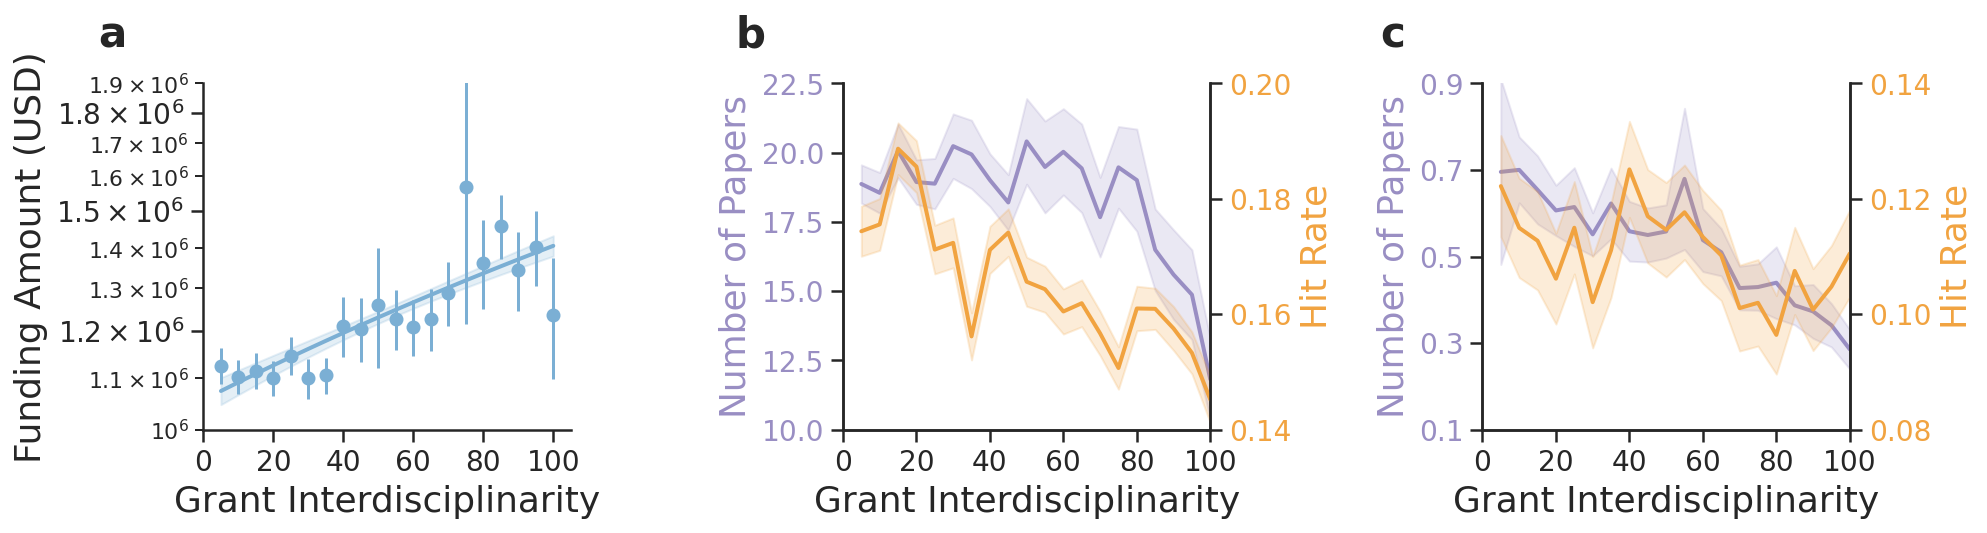

In [37]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(14,4))
gs = GridSpec(1, 3, figure=fig)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0])

x1 = funding_per_grantITD['grant_interdisciplinarity_interval']
mu1 = funding_per_grantITD['funding_usd_mean']
ci1 = funding_per_grantITD['funding_usd_ci']
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color='#7bafd4')

x2 = pred_y['grant_interdisciplinarity_interval']
mu2 = pred_y['mean_mean']
ci2 = pred_ci['mean_se_mean']
ax.plot(x2, mu2, lw=2, color='#7bafd4')
ax.fill_between(x2, mu2+ci2, mu2-ci2, alpha=0.2, color='#7bafd4')

ax.set_ylabel('Funding Amount (USD)', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.3*10**6))
plt.ylim(1.0*10**6, 1.9*10**6)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[0,1])

x = numPaper_per_grantITD_q4['grant_interdisciplinarity_interval']
mu = numPaper_per_grantITD_q4['num_paper_mean']
ci = numPaper_per_grantITD_q4['num_paper_ci']

ax.plot(x, mu, lw=2, color='#998ec3')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#998ec3')

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Number of Papers', color='#998ec3', fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14, labelcolor='#998ec3')

"""
#-For Top Quartile
plt.yticks([5.0, 7.5, 10.0, 12.5])
ax.set_yticklabels(['5.0', '7.5', '10.0', '12.5'])
plt.ylim(4.0,12.5)
"""
#-For Top 10%
plt.yticks([10.0, 12.5, 15.0, 17.5, 20.0, 22.5])
ax.set_yticklabels(['10.0', '12.5', '15.0', '17.5', '20.0', '22.5'])
plt.ylim(10,22.5)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 100)

ax2 = ax.twinx() #-Instantiate the second axis that shares the same x-axis

x = hitRate_per_grantITD_q4['grant_interdisciplinarity_interval']
mu = hitRate_per_grantITD_q4['c_hit_rate_5_lvl-0_mean']
ci = hitRate_per_grantITD_q4['c_hit_rate_5_lvl-0_ci']

ax2.plot(x, mu, lw=2, color='#f1a340')
ax2.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#f1a340')

ax2.set_ylabel('Hit Rate', color='#f1a340', fontsize=18) #-Already handled the x-label with ax
ax2.tick_params(axis='y', which='major', labelsize=14, labelcolor='#f1a340')

"""
#-For Top Quartile
plt.yticks([0.14, 0.15, 0.16, 0.17, 0.18])
ax2.set_yticklabels(['0.14', '0.15', '0.16', '0.17', '0.18'])
plt.ylim(0.135,0.18)
"""
#-For Top 10%
plt.yticks([0.14, 0.16, 0.18, 0.20])
ax2.set_yticklabels(['0.14', '0.16', '0.18', '0.20'])
plt.ylim(0.14,0.20)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- C -----#####
ax = fig.add_subplot(gs[0,2])

x = numPaper_per_grantITD_q1['grant_interdisciplinarity_interval']
mu = numPaper_per_grantITD_q1['num_paper_mean']
ci = numPaper_per_grantITD_q1['num_paper_ci']

ax.plot(x, mu, lw=2, color='#998ec3')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#998ec3')

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Number of Papers', color='#998ec3', fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14, labelcolor='#998ec3')

"""
#-For Bottom Quartile
plt.yticks([0.1, 0.15, 0.2, 0.25])
ax.set_yticklabels(['0.10', '0.15', '0.20', '0.25'])
plt.ylim(0.1,0.25)
"""
#-For Middle 10%
plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_yticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])
plt.ylim(0.1,0.9)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 100)

ax2 = ax.twinx() #-Instantiate the second axis that shares the same x-axis

x = hitRate_per_grantITD_q1['grant_interdisciplinarity_interval']
mu = hitRate_per_grantITD_q1['c_hit_rate_5_lvl-0_mean']
ci = hitRate_per_grantITD_q1['c_hit_rate_5_lvl-0_ci']

ax2.plot(x, mu, lw=2, color='#f1a340')
ax2.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#f1a340')

ax2.set_ylabel('Hit Rate', color='#f1a340', fontsize=18) #-Already handled the x-label with ax
ax2.tick_params(axis='y', which='major', labelsize=14, labelcolor='#f1a340')

"""
#-For Bottom Quartile
plt.yticks([0.045, 0.055, 0.065, 0.075])
ax2.set_yticklabels(['0.045', '0.055', '0.065', '0.075'])
plt.ylim(0.045,0.075)
"""
#-For Middle 10%
plt.yticks([0.08, 0.10, 0.12, 0.14])
ax2.set_yticklabels(['0.08', '0.10', '0.12', '0.14'])
plt.ylim(0.08,0.14)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.text(-0.21, 1.2, 'c', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/fig-4-1.pdf', format='pdf', dpi=700, bbox_inches='tight')

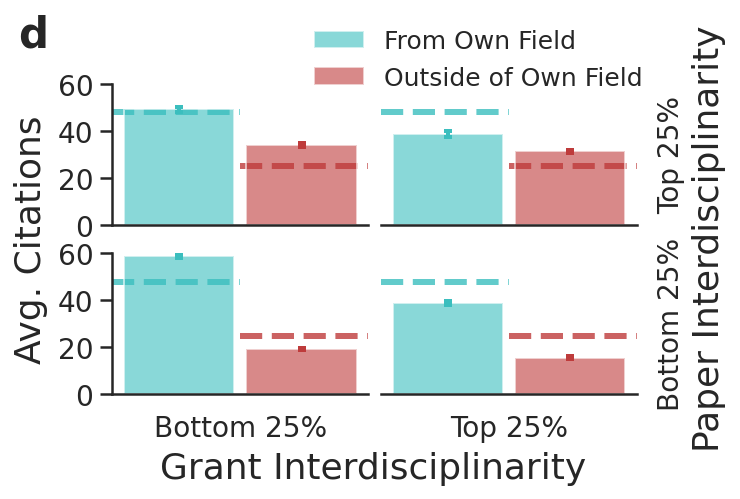

In [150]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(5.5,4))
gs = GridSpec(1, 1, figure=fig)

#####----- D -----#####
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0:2], hspace=0.2, wspace=0.05)
ax00 = plt.subplot(gs0[0,0])
ax01 = plt.subplot(gs0[0,1])
ax10 = plt.subplot(gs0[1,0])
ax11 = plt.subplot(gs0[1,1])

c1,c2 = '#3bbebe','#be3b3b'
barWidth = 0.9

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&100']
ax00.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax00.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax00.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax00.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax00.axis(ymin=0,ymax=60)
ax00.set_yticks([0, 20, 40, 60])
ax00.set_yticklabels(['0', '20', '40', '60'])
ax00.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&100']
ax01.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0], label='From Own Field',
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax01.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1], label='Outside of Own Field',
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax01.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax01.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax01.axis(ymin=0,ymax=60)
ax01.set_ylabel('Top 25%', fontsize=14, labelpad=10)
ax01.yaxis.set_label_position('right')
ax01.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
"""
ax01.legend(loc='lower left', bbox_to_anchor=(0.05, 0.8),
            fontsize=12.5, frameon=False)
"""
ax01.legend(loc='lower left', bbox_to_anchor=(-0.35, 0.8),
            fontsize=12.5, frameon=False)
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)
ax01.spines['left'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&25']
ax10.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax10.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax10.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax10.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax10.axis(ymin=0,ymax=60)
ax10.set_yticks([0, 20, 40, 60])
ax10.set_yticklabels(['0', '20', '40', '60'])
ax10.set_xlabel('Bottom 25%', fontsize=14, labelpad=10)
ax10.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&25']
ax11.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax11.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax11.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax11.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax11.axis(ymin=0,ymax=60)
ax11.set_xlabel('Top 25%', fontsize=14, labelpad=10)
ax11.set_ylabel('Bottom 25%', fontsize=14, labelpad=10)
ax11.yaxis.set_label_position('right')
ax11.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
"""
#-fig = plt.figure(figsize=(7,4.5))
ax11.text(0.55, -0.4, 'Grant Interdisciplinarity', transform=ax11.transAxes,
          size=18, va='top', ha='right')
ax11.text(1.25, 2.4, 'Paper Interdisciplinarity', transform=ax11.transAxes,
          size=18, va='top', ha='right', rotation=90)
ax11.text(-1.22, 1.86, 'Avg. Citations', transform=ax11.transAxes,
          size=18, va='top', ha='right', rotation=90)
ax11.text(-1.22, 2.7, 'd', transform=ax11.transAxes,
          fontsize=21, fontweight='bold', va='top', ha='right')
"""
ax11.text(0.8, -0.4, 'Grant Interdisciplinarity', transform=ax11.transAxes,
          size=18, va='top', ha='right')
ax11.text(1.35, 2.62, 'Paper Interdisciplinarity', transform=ax11.transAxes,
          size=18, va='top', ha='right', rotation=90)
ax11.text(-1.3, 1.98, 'Avg. Citations', transform=ax11.transAxes,
          size=18, va='top', ha='right', rotation=90)
ax11.text(-1.3, 2.7, 'd', transform=ax11.transAxes,
          fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/fig-4-2.pdf', format='pdf', dpi=700, bbox_inches='tight')

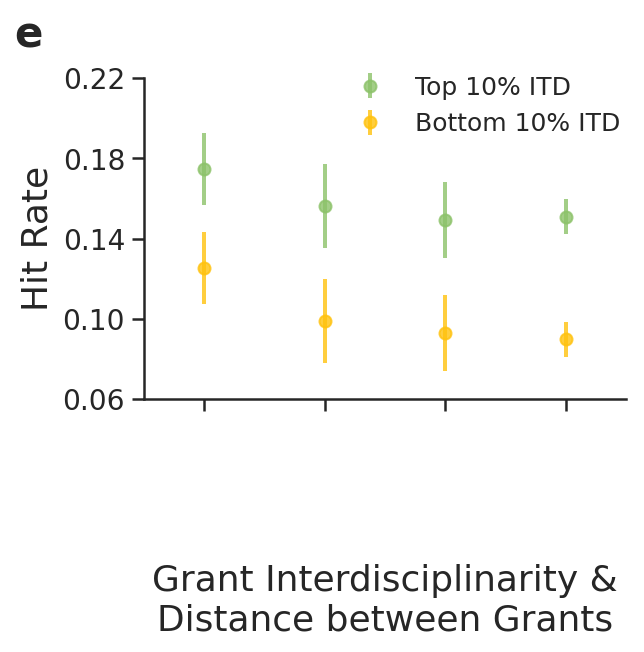

In [154]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(14*(1/3),5))
gs = GridSpec(1, 1, figure=fig)

#####----- E -----#####
ax = fig.add_subplot(gs[0,0])

c1,c2 = '#8cc269', '#ffc20e'

df_tmp = hitRate_per_paperITD_distBtwGrant[hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==100]
x1 = df_tmp['label_avg_grant_itd_n_dist_btw_grants'][::-1]
mu1 = df_tmp['c_hit_rate_5_lvl-0_mean'][::-1]
ci1 = df_tmp['c_hit_rate_5_lvl-0_ci'][::-1]
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color=c1, lw=2, alpha=0.8, label='Top 10% ITD')

df_tmp = hitRate_per_paperITD_distBtwGrant[hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==10]
x2 = df_tmp['label_avg_grant_itd_n_dist_btw_grants'][::-1]
mu2 = df_tmp['c_hit_rate_5_lvl-0_mean'][::-1]
ci2 = df_tmp['c_hit_rate_5_lvl-0_ci'][::-1]
ax.errorbar(x2, mu2, yerr=ci1, fmt='o', color=c2, lw=2, alpha=0.8, label='Bottom 10% ITD')

ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity &\nDistance between Grants', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=16)

ax.set_xlim(-0.5, 3+0.5)
positions = [0, 1, 2, 3]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
# labels = ['Bottom 25% &\nBottom 25%', 'Bottom 25% &\nTop 25%', 'Top 25% &\nBottom 25%', 'Top 25% &\nTop 25%']
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
# ax.set_xticklabels(labels, rotation=40, ha='center')
labels = ['\n\n\n', '\n\n\n', '\n\n\n', '\n\n\n']
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.yticks([0.06, 0.10, 0.14, 0.18, 0.22])
ax.set_yticklabels(['0.06', '0.10', '0.14', '0.18', '0.22'])
plt.ylim(0.06, 0.22)

ax.legend(loc='lower left', bbox_to_anchor=(0.37, 0.75),
          fontsize=12.5, frameon=False)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'e', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/fig-4-3.pdf', format='pdf', dpi=700, bbox_inches='tight')

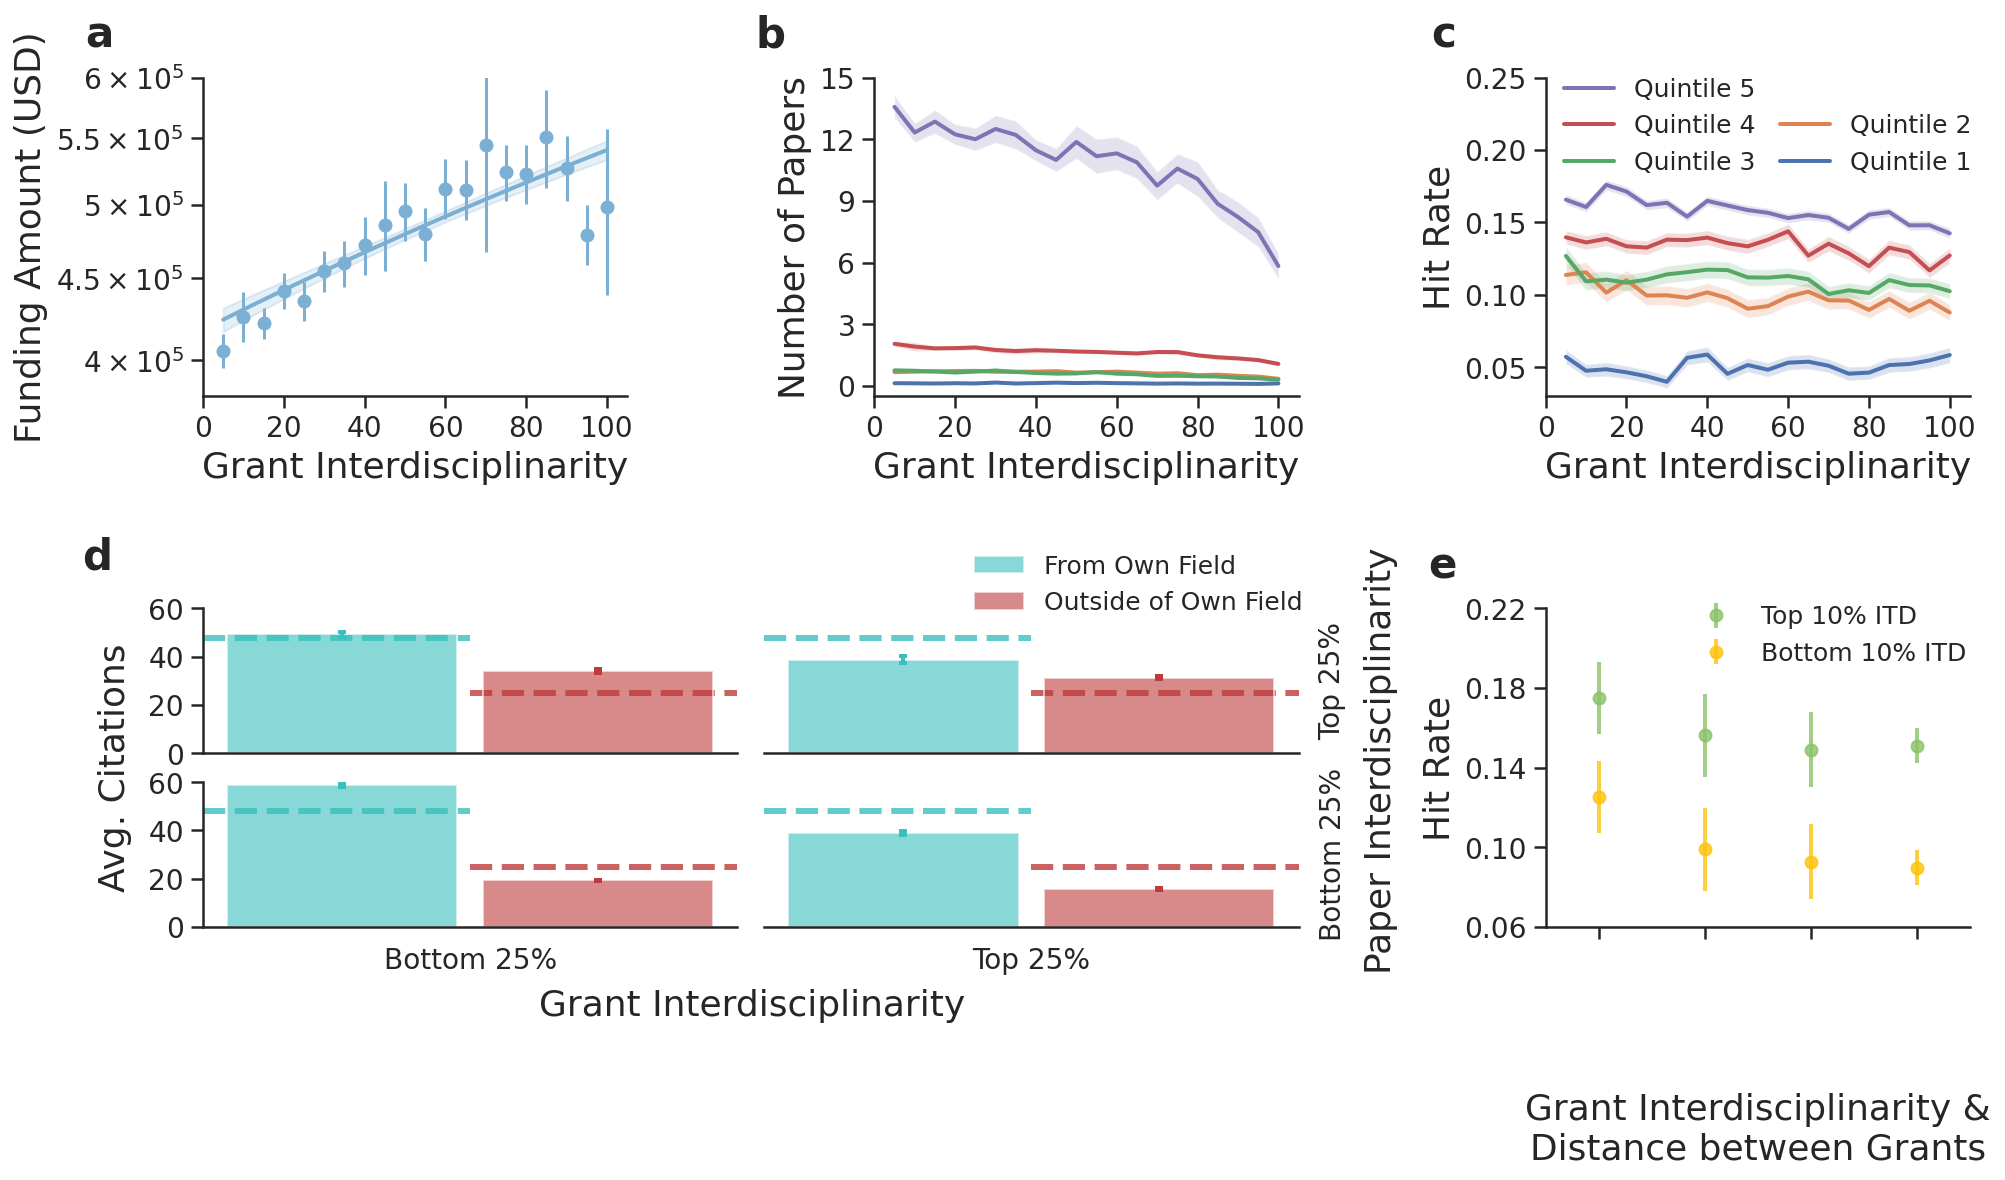

In [80]:
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(14,8.5))
gs = GridSpec(2, 3, figure=fig)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0])

x1 = funding_per_grantITD['grant_interdisciplinarity_interval']
mu1 = funding_per_grantITD['funding_usd_mean']
ci1 = funding_per_grantITD['funding_usd_ci']
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color='#7bafd4')

x2 = pred_y['grant_interdisciplinarity_interval']
mu2 = pred_y['mean_mean']
ci2 = pred_ci['mean_se_mean']
ax.plot(x2, mu2, lw=2, color='#7bafd4')
ax.fill_between(x2, mu2+ci2, mu2-ci2, alpha=0.2, color='#7bafd4')

ax.set_ylabel('Funding Amount (USD)', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.5*10**5))
plt.ylim(3.8*10**5, 6.0*10**5)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[0,1])

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in range(20,101,20):
    tmp_x.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['grant_interdisciplinarity_interval'])
    tmp_mu.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['num_paper_mean'])
    tmp_ci.append(numPaper_per_grantITD_funding[numPaper_per_grantITD_funding['funding_usd_interval']==i]['num_paper_ci'])

for i in range(0,5):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label='Quintile {}'.format(i+1))
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Number of Papers', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
plt.gca().yaxis.set_major_locator(MultipleLocator(3))
plt.ylim(-0.5, 15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- C -----#####
ax = fig.add_subplot(gs[0,2])

c = ['#006BA2','#3EBCD2','#EBB434','#DB444B','#9A607F']

tmp_x = []
tmp_mu = []
tmp_ci = []
for i in range(20,101,20):
    tmp_x.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['grant_interdisciplinarity_interval'])
    tmp_mu.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['c_hit_rate_5_lvl-0_mean'])
    tmp_ci.append(hitRate_per_grantITD_funding[hitRate_per_grantITD_funding['funding_usd_interval']==i]['c_hit_rate_5_lvl-0_ci'])

for i in range(0,5):
    ax.plot(tmp_x[i], tmp_mu[i], lw=2, label='Quintile {}'.format(i+1))
    ax.fill_between(tmp_x[i], tmp_mu[i]+tmp_ci[i], tmp_mu[i]-tmp_ci[i],
                    facecolor='C{}'.format(i), alpha=0.2)

ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.set_ylabel('Hit Rate', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
plt.ylim(0.03, 0.25)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
h = list(handles)
h.insert(3, plt.plot([], [], color=(0,0,0,0), label=' ')[0])
l = list(labels)
l.insert(3, '')
ax.legend(h, l, loc='lower left', bbox_to_anchor=(-0.01, 0.625),
          fontsize=12.5, frameon=False, ncol=2, columnspacing=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'c', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- D -----#####
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,0:2], hspace=0.2, wspace=0.05)
ax00 = plt.subplot(gs0[0,0])
ax01 = plt.subplot(gs0[0,1])
ax10 = plt.subplot(gs0[1,0])
ax11 = plt.subplot(gs0[1,1])

c1,c2 = '#3bbebe','#be3b3b'
barWidth = 0.9

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&100']
ax00.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax00.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax00.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax00.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax00.axis(ymin=0,ymax=60)
ax00.set_yticks([0, 20, 40, 60])
ax00.set_yticklabels(['0', '20', '40', '60'])
ax00.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&100']
ax01.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0], label='From Own Field',
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax01.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1], label='Outside of Own Field',
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax01.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax01.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax01.axis(ymin=0,ymax=60)
ax01.set_ylabel('Top 25%', fontsize=14, labelpad=10)
ax01.yaxis.set_label_position('right')
ax01.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax01.legend(loc='lower left', bbox_to_anchor=(0.35, 0.8),
            fontsize=12.5, frameon=False)
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)
ax01.spines['left'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='25&25']
ax10.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax10.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax10.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax10.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax10.axis(ymin=0,ymax=60)
ax10.set_yticks([0, 20, 40, 60])
ax10.set_yticklabels(['0', '20', '40', '60'])
ax10.set_xlabel('Bottom 25%', fontsize=14, labelpad=10)
ax10.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=14,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

df_tmp = c_per_grantITD_paperITD_FromOwnField[c_per_grantITD_paperITD_FromOwnField['label_avg_grant_itd_n_paper_itd']=='100&25']
ax11.bar(0, list(df_tmp['c_from_own_fos_mean'])[0], width=barWidth, color=c1, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[0],
         error_kw=dict(ecolor=c1, lw=2, capsize=2, capthick=2))
ax11.bar(1, list(df_tmp['c_from_own_fos_mean'])[1], width=barWidth, color=c2, alpha=0.6,
         yerr=list(df_tmp['c_from_own_fos_ci'])[1],
         error_kw=dict(ecolor=c2, lw=2, capsize=2, capthick=2))
ax11.axhline(47.905756, xmin=0, xmax=0.5, linestyle='--', color=c1, alpha=0.8, zorder=0, lw=3)
ax11.axhline(24.909019, xmin=0.5, xmax=1, linestyle='--', color=c2, alpha=0.8, zorder=0, lw=3)
ax11.axis(ymin=0,ymax=60)
ax11.set_xlabel('Top 25%', fontsize=14, labelpad=10)
ax11.set_ylabel('Bottom 25%', fontsize=14, labelpad=10)
ax11.yaxis.set_label_position('right')
ax11.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.text(-1.425, -37, 'Grant Interdisciplinarity', size=18)
ax11.text(1.8, -16.5, 'Paper Interdisciplinarity', size=18, rotation=90)
ax11.text(-3.15, 17.5, 'Avg. Citations', size=18, rotation=90)
ax11.text(-1.22, 2.7, 'd', transform=ax11.transAxes,
          fontsize=21, fontweight='bold', va='top', ha='right')



#####----- E -----#####
ax = fig.add_subplot(gs[1,2])

c1,c2 = '#8cc269', '#ffc20e'

df_tmp = hitRate_per_paperITD_distBtwGrant[hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==100]
x1 = df_tmp['label_avg_grant_itd_n_dist_btw_grants'][::-1]
mu1 = df_tmp['c_hit_rate_5_lvl-0_mean'][::-1]
ci1 = df_tmp['c_hit_rate_5_lvl-0_ci'][::-1]
ax.errorbar(x1, mu1, yerr=ci1, fmt='o', color=c1, lw=2, alpha=0.8, label='Top 10% ITD')

df_tmp = hitRate_per_paperITD_distBtwGrant[hitRate_per_paperITD_distBtwGrant['interdisciplinarity_reference_10p_interval']==10]
x2 = df_tmp['label_avg_grant_itd_n_dist_btw_grants'][::-1]
mu2 = df_tmp['c_hit_rate_5_lvl-0_mean'][::-1]
ci2 = df_tmp['c_hit_rate_5_lvl-0_ci'][::-1]
ax.errorbar(x2, mu2, yerr=ci1, fmt='o', color=c2, lw=2, alpha=0.8, label='Bottom 10% ITD')

ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity &\nDistance between Grants', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=16)

ax.set_xlim(-0.5, 3+0.5)
positions = [0, 1, 2, 3]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
# labels = ['Bottom 25% &\nBottom 25%', 'Bottom 25% &\nTop 25%', 'Top 25% &\nBottom 25%', 'Top 25% &\nTop 25%']
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
# ax.set_xticklabels(labels, rotation=40, ha='center')
labels = ['\n\n\n', '\n\n\n', '\n\n\n', '\n\n\n']
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
"""
l_c = [('#fea303','#fea303'),('#fea303','#b19ff9'),
       ('#b19ff9','#fea303'),('#b19ff9','#b19ff9')]
for i in positions:
    ax.annotate('   ', xy=(i,0), xytext=(0, -10 - ax.xaxis.labelpad),
                xycoords=('data','axes fraction'), textcoords='offset points',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round', fc=l_c[i][0], ec=l_c[i][0], alpha=0.7))
    ax.annotate('   ', xy=(i,0), xytext=(0, -33 - ax.xaxis.labelpad),
                xycoords=('data','axes fraction'), textcoords='offset points',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round', fc=l_c[i][1], ec=l_c[i][1], alpha=0.7))
"""

"""
ax.text(0.35, -0.38, 'Top 25%', transform=ax.transAxes,
        fontsize=12, va='top', ha='center', #fontweight='bold', 
        bbox=dict(boxstyle='round', fc='#b19ff9', ec='#b19ff9', alpha=0.7))
ax.text(0.65, -0.38, 'Bottom 25%', transform=ax.transAxes,
        fontsize=12, va='top', ha='center', #fontweight='bold', 
        bbox=dict(boxstyle='round', fc='#fea303', ec='#fea303', alpha=0.7))
ax.text(0.95, -0.0775, '— Grant ITD', transform=ax.transAxes,
        fontsize=12, va='top', ha='left')
ax.text(0.95, -0.225, '— Dist. btw Grants', transform=ax.transAxes,
        fontsize=12, va='top', ha='left')
"""

plt.yticks([0.06, 0.10, 0.14, 0.18, 0.22])
ax.set_yticklabels(['0.06', '0.10', '0.14', '0.18', '0.22'])
plt.ylim(0.06, 0.22)

ax.legend(loc='lower left', bbox_to_anchor=(0.29, 0.75),
          fontsize=12.5, frameon=False)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'e', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/fig-4.pdf', format='pdf', dpi=700, bbox_inches='tight')